# Modeling + Policy 

**Goal:** Train baseline models to predict next-day engagement, then convert predictions into a daily slate policy.

### Inputs (from Notebook 1)
- `data/processed/train_daily.parquet`
- `data/processed/valid_daily.parquet`
- `data/processed/test_daily.parquet`

### KPIs
Primary: next-day **Avg % Viewed**  
Secondary: next-day **Watch Time** (modeled as log1p)

### Policies evaluated
- Random (baseline)
- 1-stage (pct-only)
- 1-stage (watch-only)
- 1-stage (weighted score)
- 2-stage (candidates by one signal, rerank by another)

## 1. Why regression accuracy is not the final goal

This project is **ranking-first**, not pure forecasting.

Even if regression R² is modest, the model can still be useful if it ranks high-performing videos near the top.

**Decision lens:**
- We care about the quality of the **top K** items we show.
- This is closer to recommendation / retrieval than to pure prediction.

In [58]:
from pathlib import Path
import pandas as pd
import numpy as np

REPO = Path("..")
PROC = REPO / "data" / "processed"

train_df = pd.read_parquet(PROC / "train_daily.parquet")
valid_df = pd.read_parquet(PROC / "valid_daily.parquet")
test_df  = pd.read_parquet(PROC / "test_daily.parquet")

train_df.shape, valid_df.shape, test_df.shape

((60382, 17), (20240, 17), (19954, 17))

In [59]:
feat_cols = [
    "views_daily","likes_added_daily","dislikes_added_daily","likes_removed_daily",
    "comments_added_daily","subs_added_daily","subs_removed_daily","video_length"
]

target_pct = "y_next_avg_pct_viewed"
target_watchlog = "y_next_watch_time_log"

X_tr, X_va, X_te = train_df[feat_cols], valid_df[feat_cols], test_df[feat_cols]
y1_tr, y1_va, y1_te = train_df[target_pct], valid_df[target_pct], test_df[target_pct]
y2_tr, y2_va, y2_te = train_df[target_watchlog], valid_df[target_watchlog], test_df[target_watchlog]

## 2. Baseline models

We train two models (one per KPI):
- Model A predicts next-day Avg % Viewed
- Model B predicts next-day Watch Time (log space)

**Why tree-based baseline?**
- handles non-linear patterns
- minimal feature engineering
- strong out-of-box performance on tabular data

In [60]:
from sklearn.ensemble import HistGradientBoostingRegressor

m_pct = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.05, max_iter=300, random_state=42)
m_wt  = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.05, max_iter=300, random_state=42)

m_pct.fit(X_tr, y1_tr)
m_wt.fit(X_tr, y2_tr)

,loss,'squared_error'
,quantile,None
,learning_rate,0.05
,max_iter,300
,max_leaf_nodes,31
,max_depth,6
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


## 3. Model evaluation metrics

For regression:
- **MAE**: average absolute error (easy to interpret)
- **RMSE**: penalizes large errors more than MAE
- **R²**: variance explained (not always high for noisy engagement data)

For policies (ranking):
- We compare **true next-day KPIs** achieved by each slate policy.

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_reg(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:.4f}  RMSE={rmse:.4f}  R2={r2:.4f}")

p1_va = m_pct.predict(X_va)
p1_te = m_pct.predict(X_te)

p2_va = m_wt.predict(X_va)
p2_te = m_wt.predict(X_te)

eval_reg("PctViewed VALID", y1_va, p1_va)
eval_reg("PctViewed TEST ", y1_te, p1_te)
eval_reg("WatchLog  VALID", y2_va, p2_va)
eval_reg("WatchLog  TEST ", y2_te, p2_te)

PctViewed VALID: MAE=0.1247  RMSE=0.1792  R2=0.3661
PctViewed TEST : MAE=0.1363  RMSE=0.1894  R2=0.3557
WatchLog  VALID: MAE=0.5589  RMSE=0.9200  R2=0.2473
WatchLog  TEST : MAE=0.5998  RMSE=0.9579  R2=0.2322


In [62]:
scored_te = test_df[["date","video_id","video_title"]].copy()
scored_te["pred_pct"] = p1_te
scored_te["pred_watch_log"] = p2_te

# For evaluation later (true outcomes)
scored_te["true_pct"] = y1_te.values
scored_te["true_watch_log"] = y2_te.values

score_tr = train_df[['video_id','video_title','date',"video_length"]].copy()
score_va = valid_df[['video_id','video_title','date',"video_length"]].copy()
score_te = test_df[['video_id','video_title','date',"video_length"]].copy()

score_tr["true_pct"] = y1_tr.values
score_va["true_pct"] = y1_va.values
score_te["true_pct"] = y1_te.values

score_tr["true_watch_log"] = y2_tr.values
score_va["true_watch_log"] = y2_va.values
score_te["true_watch_log"] = y2_te.values

# Add predictions
score_va['pred_pct'] = p1_va
score_te['pred_pct'] = p1_te

score_va['pred_watch_log'] = p2_va
score_te['pred_watch_log'] = p2_te

score_va.head()

,video_id,video_title,date,video_length,true_pct,true_watch_log,pred_pct,pred_watch_log
0,-ONQ628CXKQ,Data Scientist Reacts: REAL Data Science Job A...,2021-04-29,964,0.333016,5.774636,0.278311,5.566306
1,-kX2b6TF_9k,By The Numbers: Where Should The NBA Put a 4 P...,2021-04-29,656,0.707652,6.142509,0.268401,4.562946
2,-pdXWmj9xxU,How I Learn Data Science Through Studying Othe...,2021-04-29,866,0.019097,2.864362,0.329556,5.526213
3,1Cf7SdnBncg,My Top 5 Data Science Internship Tips,2021-04-29,482,0.476266,5.440512,0.438879,5.321030
4,1FrY7ARSf10,9 Ways You Can Make Extra Income as a Data Sci...,2021-04-29,638,0.352966,5.421385,0.378033,5.478148


## 4. Score construction for balanced ranking

The two model outputs are in different units and scales.

We standardize predictions (z-score) before combining:

- `pred_pct_z`
- `pred_watch_z`

Then build a weighted score:

`score_weighted = w * pred_pct_z + (1-w) * pred_watch_z`

**Interpretation:**
- increasing w favors retention quality (avg % viewed)
- decreasing w favors total consumption (watch time)

In [63]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

scaler.fit(np.c_[score_va['pred_pct'], score_va['pred_watch_log']])

score_va[['pred_pct_z','pred_watch_z']] = scaler.transform(
    np.c_[score_va['pred_pct'], score_va['pred_watch_log']]
)

score_te[['pred_pct_z','pred_watch_z']] = scaler.transform(
    np.c_[score_te['pred_pct'], score_te['pred_watch_log']]
)

In [64]:
def add_weighted_score(df, w_pct=0.7):
    out = df.copy()
    out["pred_pct_z"] = (out["pred_pct"] - out["pred_pct"].mean()) / out["pred_pct"].std(ddof=0)
    out["pred_watch_z"] = (out["pred_watch_log"] - out["pred_watch_log"].mean()) / out["pred_watch_log"].std(ddof=0)
    out["score_weighted"] = w_pct * out["pred_pct_z"] + (1 - w_pct) * out["pred_watch_z"]
    return out
    
score_va = add_weighted_score(score_va, w_pct=0.7)
score_te = add_weighted_score(score_te, w_pct=0.7)

## 5. One-stage ranking policy

For each day:
1) compute score for each candidate video
2) sort by the score
3) take Top-K → daily slate

This matches a simple recommender: “pick top items by predicted value”.

## 5.1 Baseline policy: Random slate selection (no model)

Before using any scoring model, we need a **true baseline** that represents “what happens if we pick videos without intelligence”.

**Policy idea**
- For each decision day *t*, randomly select **K videos** from the candidate pool.
- This simulates a naive recommendation / promotion rule with **no learning**.

**Why we need it**
- It lets us measure **uplift** from smarter policies (pct-only / watch-only / weighted / 2-stage).
- It protects us from misleading comparisons (e.g., comparing only against overall dataset average).

In [65]:
K = 100
SEED = 42

def random_slate(df, K=100, seed=42):
    # pick K random items per day
    return (df.groupby("date", group_keys=False)
              .apply(lambda g: g.sample(n=min(K, len(g)), random_state=seed)))

In [66]:
slate_rand_va = random_slate(score_va, K=K, seed=SEED)

/var/folders/23/ffpfhtdx4wx901rhxgr55x4w0000gn/T/ipykernel_36289/3457895906.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(K, len(g)), random_state=seed)))


In [67]:
base_pct = slate_rand_va["true_pct"].mean()
base_watch_log = slate_rand_va["true_watch_log"].mean()
base_watch_real = np.expm1(slate_rand_va["true_watch_log"]).mean()

print("VALID baseline (random slate) pct:", base_pct)
print("VALID baseline (random slate) watch_log:", base_watch_log)
print("VALID baseline (random slate) watch_real:", base_watch_real)

VALID baseline (random slate) pct: 0.34155411957095466
VALID baseline (random slate) watch_log: 5.005625625772237
VALID baseline (random slate) watch_real: 219.52959292824443


## 5.2 1-stage policy: Pct-only ranking (maximize completion depth)

This policy ranks videos using a **single predicted KPI**: next-day completion depth.

**Policy idea**
- For each decision day *t*, rank all candidate videos by predicted next-day average % viewed (`pred_pct`) in descending order.
- Select the top **K videos** as the slate.

**Why we need it**
- It is the simplest “optimize one KPI” policy.
- It provides a clear benchmark for how much completion depth can be improved when we only optimize `% viewed`.

**Expected behavior**
- ↑ Avg % viewed  
- ↓ Watch time (often), because it tends to over-select shorter videos that are easier to finish.



In [68]:
def pct_slate(df, K=100, label=None):
    out = (df.sort_values(["date", "pred_pct"], ascending=[True, False])
             .groupby("date", group_keys=False)
             .head(K))
    return out

In [69]:
slate_pct_va = pct_slate(score_va, K=K)

In [70]:
pct_slate_pct = slate_pct_va["true_pct"].mean()
pct_slate_watch_log = slate_pct_va["true_watch_log"].mean()
pct_slate_watch_real = np.expm1(slate_pct_va["true_watch_log"]).mean()

print("VALID (pct-only slate) pct:", pct_slate_pct, "lift:", pct_slate_pct - base_pct)
print("VALID (pct-only slate) watch_log:", pct_slate_watch_log, "lift:", pct_slate_watch_log - base_watch_log)
print("VALID (pct-only slate) watch_real:", pct_slate_watch_real, "lift:", pct_slate_watch_real - base_watch_real)

VALID (pct-only slate) pct: 0.4344359624019802 lift: 0.09288184283102552
VALID (pct-only slate) watch_log: 4.89646314325049 lift: -0.10916248252174654
VALID (pct-only slate) watch_real: 173.23818516818804 lift: -46.29140776005639



## 5.3 1-stage policy: Watch-only ranking (maximize total watch time)

This policy ranks videos using a **single predicted KPI**: next-day watch time.

**Policy idea**
- For each decision day *t*, rank all candidate videos by predicted next-day watch time (log space) (`pred_watch_log`) in descending order.
- Select the top **K videos** as the slate.

**Why we need it**
- It is the “watch-time maximizer” counterpart to pct-only.
- It helps reveal the trade-off: optimizing for total minutes watched can reduce completion fraction.

**Expected behavior**
- ↑ Watch time  
- ↓ Avg % viewed (often), because it tends to favor longer videos.

> Note: watch time is modeled in log space for stability, but reported in real units using `expm1()`.

In [71]:
def watch_slate(df, K=100, label=None):
    out = (df.sort_values(["date", "pred_watch_log"], ascending=[True, False])
             .groupby("date", group_keys=False)
             .head(K))
    return out

In [72]:
slate_watch_va = watch_slate(score_va, K=100)

In [73]:
watch_slate_pct = slate_watch_va["true_pct"].mean()
watch_slate_watch_log = slate_watch_va["true_watch_log"].mean()
watch_slate_watch_real = np.expm1(slate_watch_va["true_watch_log"]).mean()

print("VALID (watch-only slate) pct:", watch_slate_pct, "lift:", watch_slate_pct - base_pct)
print("VALID (watch-only slate) watch_log:", watch_slate_watch_log, "lift:", watch_slate_watch_log - base_watch_log)
print("VALID (watch-only slate) watch_real:", watch_slate_watch_real, "lift:", watch_slate_watch_real - base_watch_real)

VALID (watch-only slate) pct: 0.3149077216253432 lift: -0.026646397945611466
VALID (watch-only slate) watch_log: 5.31657636274177 lift: 0.31095073696953346
VALID (watch-only slate) watch_real: 252.50036847045953 lift: 32.97077554221511


## 5.4 1-stage policy: Balanced weighted score (explicit KPI trade-off)

This policy combines two predicted KPIs into a **single ranking score** so we can directly control the trade-off.

**Policy idea**
- Standardize predictions into z-scores within the split:
  - `pred_pct_z = zscore(pred_pct)`
  - `pred_watch_z = zscore(pred_watch_log)`
- Compute a weighted score:

**Score:** `score = w_pct · z(pred_pct) + (1 - w_pct) · z(pred_watch_log)`

- For each day *t*, rank candidates by `score` and select top **K**.

**Why we need it**
- It is a simple and interpretable way to **balance competing objectives**.
- It avoids the extreme behavior of pct-only (short-video completion optimizer) and watch-only (long-video watch-time maximizer).

**How we tune it**
- Sweep \( w_{\text{pct}} \in [0,1] \) on **VALID** and pick a weight that delivers a reasonable balance:
  - meaningful uplift in `% viewed`, and
  - watch time not collapsing (ideally ≥ baseline).
- Lock the chosen weight and evaluate once on **TEST**.


In [74]:
K = 100

def make_topk_by_weight(df, w_pct):
    w_watch = 1 - w_pct
    tmp = df.copy()
    tmp["score_w"] = w_pct*tmp["pred_pct_z"] + w_watch*tmp["pred_watch_z"]

    topk = (tmp.sort_values(["date","score_w"], ascending=[True, False])
              .groupby("date", group_keys=False)
              .head(K))
    return topk

def slate_metrics(slate_df, label="", base_pct = base_pct, base_watch_real = base_watch_real):
    # slate performance
    slate_pct = slate_df["true_pct"].mean()
    slate_watch = np.expm1(slate_df["true_watch_log"]).mean()
    
    out = {
        "label": label,
        "pct_baseline": base_pct,
        "pct_slate": slate_pct,
        "pct_uplift": slate_pct - base_pct,
        "watch_baseline": base_watch_real,
        "watch_slate": slate_watch,
        "watch_uplift": slate_watch - base_watch_real,
    }
    return out

rows = []
for w_pct in np.linspace(0.1, 0.9, 17):   # 0.10, 0.15, ... 0.90
    topk_weighted = make_topk_by_weight(score_va, w_pct)
    m = slate_metrics(topk_weighted, label=f"w_pct={w_pct:.2f}")
    rows.append(m)

res = pd.DataFrame(rows).sort_values("pct_uplift", ascending=False)
res

,label,pct_baseline,pct_slate,pct_uplift,watch_baseline,watch_slate,watch_uplift
16,w_pct=0.90,0.341554,0.434250,0.092696,219.529593,174.452681,-45.076912
15,w_pct=0.85,0.341554,0.433758,0.092204,219.529593,175.005791,-44.523802
14,w_pct=0.80,0.341554,0.433261,0.091707,219.529593,175.668674,-43.860919
13,w_pct=0.75,0.341554,0.432357,0.090803,219.529593,177.096764,-42.432829
12,w_pct=0.70,0.341554,0.430369,0.088815,219.529593,179.671105,-39.858488
11,w_pct=0.65,0.341554,0.422757,0.081203,219.529593,189.486074,-30.043519
10,w_pct=0.60,0.341554,0.406566,0.065012,219.529593,205.682041,-13.847551
9,w_pct=0.55,0.341554,0.393937,0.052383,219.529593,216.111897,-3.417696
8,w_pct=0.50,0.341554,0.387712,0.046158,219.529593,222.156329,2.626736
7,w_pct=0.45,0.341554,0.376841,0.035287,219.529593,227.609881,8.080288


In [75]:
slate_balanced_va = make_topk_by_weight(score_va, w_pct=0.5)

### What this sweep shows
We sweep `w_pct` from **0.10 → 0.90** and evaluate the resulting Top-K slates on **VALID**.

- As `w_pct` increases, the policy emphasizes **Avg % viewed** more:
  - `pct_uplift` increases (good), but `watch_uplift` becomes strongly negative (bad).
- As `w_pct` decreases, the policy emphasizes **watch time** more:
  - `watch_uplift` increases (good), but `pct_uplift` shrinks and can turn negative (bad).

### Selected setting: `w_pct = 0.50` (balanced)
We choose **`w_pct = 0.50`** as a **balanced compromise**:
- It still delivers a **meaningful uplift** in Avg % viewed,
- while keeping watch-time loss **small / near break-even** compared to higher `w_pct` values.

This tuning is done on **VALID** only. After selecting `w_pct = 0.50`, we will re-run the policy once on **TEST** for the final, unbiased evaluation.

In [76]:
balanced_slate_pct = slate_balanced_va["true_pct"].mean()
balanced_slate_watch_log = slate_balanced_va["true_watch_log"].mean()
balanced_slate_watch_real = np.expm1(slate_balanced_va["true_watch_log"]).mean()

print("VALID (watch-only slate) pct:", balanced_slate_pct, "lift:", balanced_slate_pct - base_pct)
print("VALID (watch-only slate) watch_log:", balanced_slate_watch_log, "lift:", balanced_slate_watch_log - base_watch_log)
print("VALID (watch-only slate) watch_real:", balanced_slate_watch_real, "lift:", balanced_slate_watch_real - base_watch_real)

VALID (watch-only slate) pct: 0.3877122806476594 lift: 0.04615816107670473
VALID (watch-only slate) watch_log: 5.215217976678843 lift: 0.20959235090660577
VALID (watch-only slate) watch_real: 222.15632878647602 lift: 2.626735858231598


## 5.5 2-stage policy: Filter by completion, then rank by watch time (pct → watch)

This policy uses a two-step pipeline to reflect how real recommender systems often operate.

**Policy idea**
1. **Stage 1 (filter):** for each day *t*, take the top **N** candidates by predicted completion depth (`pred_pct`).
2. **Stage 2 (rank):** within those N candidates, rank by predicted watch time (`pred_watch_log`) and select the top **K**.

**Why we need it**
- It simulates a realistic **retrieval → ranking** workflow:
  - Stage 1 ensures “good enough” completion quality,
  - Stage 2 optimizes watch time within that filtered pool.
- It provides an alternative to weighted scoring for managing KPI trade-offs.

**Expected behavior**
- ↑ Watch time compared to pct-only  
- ↓ Avg % viewed compared to pct-only  
- Results are sensitive to **N** (the filter width).

**How we tune it**
- Choose **N** using **VALID** (e.g., N = 200/500/1000), then lock it for **TEST**.

In [77]:
def two_stage_slate(df, N, K):
    # stage 1: candidate generation
    cand = (df.sort_values(["date", "pred_pct"], ascending=[True, False])
              .groupby("date", group_keys=False)
              .head(N))
    
    # stage 2: rerank + final slate 
    out = (cand.sort_values(["date", "pred_watch_log"], ascending=[True, False])
              .groupby("date", group_keys=False)
              .head(K))

    return out

**Why N matters**
- When **N is small**, Stage 1 is a strong *completion gate*. This protects completion depth but may filter out long videos with high watch time.
- When **N is large**, the completion gate becomes weak. The final Top-K will increasingly resemble a **watch-only** policy.

**Diagnostic: overlap with watch-only**
To check when two-stage collapses into watch-only, we compute the fraction of selected items that overlap with the watch-only slate.
If overlap reaches **~1.0**, increasing N further will not change the final slate.

In our results, overlap becomes **1.0 at N ≥ 200**, meaning two-stage is effectively identical to watch-only beyond that point.
Therefore, we tune **N < 200** on VALID to preserve the intended “completion-gated watch optimization” behavior.

In [98]:
for N in [110, 125, 150, 200, 300, 500, 800]:
    two = two_stage_slate(score_va, N=N, K=100)
    two_keys = two["date"].astype(str) + "|" + two["video_id"].astype(str)
    watch_keys = slate_watch_va["date"].astype(str) + "|" + slate_watch_va["video_id"].astype(str)
    overlap = len(set(two_keys) & set(watch_keys)) / len(set(two_keys))
    print(f"N={N}: overlap with watch-only = {overlap:.3f}")

N=110: overlap with watch-only = 0.600
N=125: overlap with watch-only = 0.698
N=150: overlap with watch-only = 0.885
N=200: overlap with watch-only = 1.000
N=300: overlap with watch-only = 1.000
N=500: overlap with watch-only = 1.000
N=800: overlap with watch-only = 1.000


### Selected N (VALID)

We select **N = 150** on VALID because it provides a meaningful watch-time lift while still maintaining a completion constraint (i.e., it does *not* collapse into watch-only as happens when N ≥ 200).

After fixing N on VALID, we lock this hyperparameter and evaluate the final two-stage policy once on **TEST**.

In [79]:
slate_two_stage_va = two_stage_slate(score_va,N=150,K=100)

In [93]:
two_stage_slate_pct = slate_two_stage_va["true_pct"].mean()
two_stage_slate_watch_log = slate_two_stage_va["true_watch_log"].mean()
two_stage_slate_watch_real = np.expm1(slate_two_stage_va["true_watch_log"]).mean()

print("VALID (two-stage slate) pct:", two_stage_slate_pct, "lift:", two_stage_slate_pct - base_pct)
print("VALID (two-stage slate) watch_log:", two_stage_slate_watch_log, "lift:", two_stage_slate_watch_log - base_watch_log)
print("VALID (two-stage slate) watch_real:", two_stage_slate_watch_real, "lift:", two_stage_slate_watch_real - base_watch_real)

VALID (two-stage slate) pct: 0.3433387804200083 lift: -0.006446219579991697
VALID (two-stage slate) watch_log: 5.2640523352736635 lift: 0.25842670950142654
VALID (two-stage slate) watch_real: 233.65202482049628 lift: 14.122431892251853


In [81]:
import numpy as np
import pandas as pd

def eval_slate_true(df_slate,label = '',base_pct = base_pct, base_watch_real = base_watch_real):
    out = {}
    out["label"] = label

    slate_pct = df_slate["true_pct"].mean()
    slate_watch_real = np.expm1(df_slate["true_watch_log"]).mean()

    out["pct_baseline"] = base_pct
    out["pct_slate"] = slate_pct
    out["pct_uplift"] = slate_pct - base_pct

    out["watch_baseline"] = base_watch_real
    out["watch_slate"] = slate_watch_real
    out["watch_uplift"] = slate_watch_real - base_watch_real

    return out


rows = []
rows.append(eval_slate_true(slate_rand_va, "VALID | random baseline (K=100)"))
rows.append(eval_slate_true(slate_pct_va,  "VALID | 1-stage (pct-only)"))
rows.append(eval_slate_true(slate_watch_va, "VALID | 1-stage (watch-only)"))
rows.append(eval_slate_true(slate_balanced_va,  "VALID | 1-stage (weighted, w_pct=0.50)"))
rows.append(eval_slate_true(slate_two_stage_va, "VALID | 2-stage (pct→watch)"))

valid_compare = pd.DataFrame(rows)

policy_order = [
    "VALID | random baseline (K=100)",
    "VALID | 1-stage (pct-only)",
    "VALID | 1-stage (watch-only)",
    "VALID | 1-stage (weighted, w_pct=0.50)",
    "VALID | 2-stage (pct→watch)",
]
valid_compare["label"] = pd.Categorical(valid_compare["label"], categories=policy_order, ordered=True)
valid_compare = valid_compare.sort_values("label").reset_index(drop=True)

valid_compare

,label,pct_baseline,pct_slate,pct_uplift,watch_baseline,watch_slate,watch_uplift
0,VALID | random baseline (K=100),0.341554,0.341554,0.000000,219.529593,219.529593,0.000000
1,VALID | 1-stage (pct-only),0.341554,0.434436,0.092882,219.529593,173.238185,-46.291408
2,VALID | 1-stage (watch-only),0.341554,0.314908,-0.026646,219.529593,252.500368,32.970776
3,"VALID | 1-stage (weighted, w_pct=0.50)",0.341554,0.387712,0.046158,219.529593,222.156329,2.626736
4,VALID | 2-stage (pct→watch),0.341554,0.343339,0.001785,219.529593,233.652025,14.122432


In [82]:
import os
os.makedirs("../reports/tables", exist_ok=True)

valid_compare.to_csv("../reports/tables/valid_policy_comparison.csv", index=False)

md = valid_compare.to_markdown(index=False)  # requires tabulate; if missing, skip
with open("../reports/tables/valid_policy_comparison.md", "w") as f:
    f.write(md)

## 5.6 Policy Selection on VALID: choose a balanced weighted policy (w_pct = 0.50)

We compare policies on the VALID split using **true next-day KPIs** (evaluation uses `true_pct` and `true_watch_*`),
while slate selection uses the model predictions (`pred_pct`, `pred_watch_log`).

**Decision Rule:**

We prioritize policies that improve Avg % Viewed **without decreasing** Watch Time, since pushing completion at the cost of session duration can reduce long-term retention.

**Observed trade-off (VALID):**
- **Pct-only** delivers the largest gain in completion depth (**+0.0929 pct_uplift**) but substantially reduces watch time (**-46.29 watch_uplift**).
- **Watch-only** increases watch time (**+32.97 watch_uplift**) but reduces completion (**-0.0266 pct_uplift**).
- **2-stage (pct→watch)** improves watch time (**+14.12**) but yields almost no completion gain (**+0.0018**).
- **Weighted (w_pct=0.50)** improves completion (**+0.0462**) while keeping watch time **non-negative** (**+2.63**).

✅ We select **weighted w_pct = 0.50** as the final policy because it provides a **balanced improvement**
(positive completion uplift without sacrificing watch time).  
After selecting the policy on VALID, we **lock the hyperparameters** and evaluate once on TEST.

## 6. TEST: Final policy evaluation (hold-out only)

This section is the **final report**.  
We run the **same policies** on the **TEST split** and evaluate them **once** (no more tuning).

**Principle**
- **VALID = choose policy + tune hyperparameters** (e.g., `w_pct`, `N_candidates`)
- **TEST = final unbiased evaluation** (do not change anything after seeing results)

If we tune on TEST, the reported performance becomes optimistic and not trustworthy.

## 6.1 Locked setup from VALID (no more changes)

From the VALID stage, we lock the operational settings:

- Slate size: **K = 100**
- Balanced weighted policy: **w_pct = 0.50**
- 2-stage candidate pool size: **N_candidates = 150**
- Random seed: **SEED = 42**

On TEST, we **only re-run** and **report** results under these fixed settings.

In [83]:
K = 100
w_pct = 0.5
N = 150
SEED = 42

## 6.2 Selection vs evaluation (the key idea)

It is easy to get messy here, so we follow one clean rule:

### Selection (what we *use* to pick videos)
We rank candidates by **predicted signals**:
- `pred_pct` (predicted next-day avg % viewed)
- `pred_watch_log` (predicted next-day watch time, modeled in log space)
- or a weighted score combining them

### Evaluation (what we *use* to judge policies)
We score the selected slate using **true realized outcomes**:
- `true_pct` (actual next-day avg % viewed)
- `true_watch` / `true_watch_log` (actual next-day watch time)

✅ Policies are chosen by **predictions**, but judged by **true outcomes**.

## 6.3 Baseline on TEST: Random slate selection (no model)

Before any “smart” ranking policy, we need a baseline that represents doing nothing intelligent.

**Policy idea**
- For each day *t*, randomly pick **K videos** from the candidate pool.

**Why we need it**
- It gives a fair comparison point for all model-based policies.
- It prevents misleading comparisons against the full dataset mean (which is not a real decision rule).

In [84]:
slate_rand_te = random_slate(score_te, K=K, seed=SEED)

/var/folders/23/ffpfhtdx4wx901rhxgr55x4w0000gn/T/ipykernel_36289/3457895906.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(K, len(g)), random_state=seed)))


In [85]:
base_pct_te = slate_rand_te["true_pct"].mean()
base_watch_log_te = slate_rand_te["true_watch_log"].mean()
base_watch_real_te = np.expm1(slate_rand_te["true_watch_log"]).mean()

print("TEST baseline (random slate) pct:", base_pct_te)
print("TEST baseline (random slate) watch_log:", base_watch_log_te)
print("TEST baseline (random slate) watch_real:", base_watch_real_te)

TEST baseline (random slate) pct: 0.3497845788682943
TEST baseline (random slate) watch_log: 4.92988557963308
TEST baseline (random slate) watch_real: 211.42510066821822


## 6.4 Policy set on TEST (re-run the same candidates)

We evaluate the same family of policies as in VALID:

**1-stage policies**
- pct-only: rank by `pred_pct`
- watch-only: rank by `pred_watch_log`
- weighted: rank by `score_weighted` with **w_pct = 0.50**

**2-stage policy**
- Stage 1: shortlist top **N_candidates = 150** by `pred_pct`
- Stage 2: from the shortlist, select top **K = 100** by `pred_watch_log`

We do not invent new policies at this point.

In [86]:
slate_pct_te = pct_slate(score_te, K=K)
slate_watch_te = watch_slate(score_te, K=K)
slate_balanced_te = make_topk_by_weight(score_te, w_pct=w_pct)
slate_two_stage_te = two_stage_slate(score_te,N=N,K=K)

## 6.5 TEST evaluation metrics 

For each policy, we compute performance using **true realized KPIs**:

- **Avg % viewed (true)** on the selected slate
- **Avg watch time (true)** on the selected slate
- **Uplift vs random baseline** (difference compared to random slate)

This answers: “If we deployed this policy, what would the selected videos look like in terms of real outcomes?”

In [101]:
rows = []
rows.append(eval_slate_true(slate_rand_te, "TEST | random baseline (K=100)",base_pct = base_pct_te, base_watch_real = base_watch_real_te))
rows.append(eval_slate_true(slate_pct_te,  "TEST | 1-stage (pct-only)",base_pct = base_pct_te, base_watch_real = base_watch_real_te))
rows.append(eval_slate_true(slate_watch_te, "TEST | 1-stage (watch-only)",base_pct = base_pct_te, base_watch_real = base_watch_real_te))
rows.append(eval_slate_true(slate_balanced_te,  "TEST | 1-stage (weighted, w_pct=0.50)",base_pct = base_pct_te, base_watch_real = base_watch_real_te))
rows.append(eval_slate_true(slate_two_stage_te, "TEST | 2-stage (pct→watch)",base_pct = base_pct_te, base_watch_real = base_watch_real_te))

test_compare = pd.DataFrame(rows)

policy_order = [
    "TEST | random baseline (K=100)",
    "TEST | 1-stage (pct-only)",
    "TEST | 1-stage (watch-only)",
    "TEST | 1-stage (weighted, w_pct=0.50)",
    "TEST | 2-stage (pct→watch)",
]
test_compare["label"] = pd.Categorical(test_compare["label"], categories=policy_order, ordered=True)
test_compare = test_compare.sort_values("label").reset_index(drop=True)

test_compare

,label,pct_baseline,pct_slate,pct_uplift,watch_baseline,watch_slate,watch_uplift
0,TEST | random baseline (K=100),0.349785,0.349785,0.000000,211.425101,211.425101,0.000000
1,TEST | 1-stage (pct-only),0.349785,0.445694,0.095909,211.425101,164.956516,-46.468585
2,TEST | 1-stage (watch-only),0.349785,0.311967,-0.037818,211.425101,245.616420,34.191319
3,"TEST | 1-stage (weighted, w_pct=0.50)",0.349785,0.390925,0.041141,211.425101,213.264905,1.839804
4,TEST | 2-stage (pct→watch),0.349785,0.353088,0.003304,211.425101,219.801734,8.376633


In [103]:
import os
os.makedirs("../reports/tables", exist_ok=True)

test_compare.to_csv("../reports/tables/test_policy_comparison.csv", index=False)

md = test_compare.to_markdown(index=False)  # requires tabulate; if missing, skip
with open("../reports/tables/test_policy_comparison.md", "w") as f:
    f.write(md)

### TEST Results Summary (vs Random Baseline)

- **1-stage (pct-only)**: large improvement in completion depth, but large watch-time loss  
  - Avg % Viewed uplift: **+0.0959**  
  - Watch Time uplift: **−46.47**

- **1-stage (watch-only)**: large watch-time gain, but lower completion depth  
  - Avg % Viewed uplift: **−0.0378**  
  - Watch Time uplift: **+34.19**

- **1-stage (weighted, w_pct=0.50)**: balanced improvements on both KPIs  
  - Avg % Viewed uplift: **+0.0411**  
  - Watch Time uplift: **+1.84**

- **2-stage (pct→watch)**: modest watch-time gain with near-flat completion depth  
  - Avg % Viewed uplift: **+0.0033**  
  - Watch Time uplift: **+8.38**

### Final Choice

We select **1-stage weighted (w_pct=0.50)** as the final ranking policy because it is the only approach that achieves **positive uplift on both KPIs** on TEST, avoiding the extreme trade-offs of pct-only (completion optimizer) and watch-only (watch-time maximizer).

### 7. Visualization

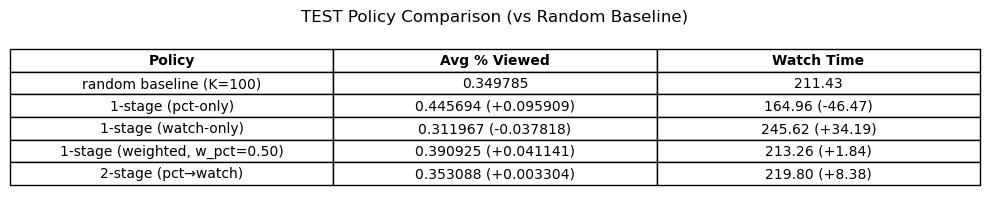

Saved: ../reports/figures/test_policy_comparison.png


In [89]:
import matplotlib.pyplot as plt

base_pct = 0.349785
base_watch = 211.425101

rows = [
    ["random baseline (K=100)",
     f"{base_pct:.6f}",
     f"{base_watch:.2f}"],

    ["1-stage (pct-only)",
     f"{0.445694:.6f} ({0.095909:+.6f})",
     f"{164.956516:.2f} ({-46.468585:+.2f})"],

    ["1-stage (watch-only)",
     f"{0.311967:.6f} ({-0.037818:+.6f})",
     f"{245.616420:.2f} ({34.191319:+.2f})"],

    ["1-stage (weighted, w_pct=0.50)",
     f"{0.390925:.6f} ({0.041141:+.6f})",
     f"{213.264905:.2f} ({1.839804:+.2f})"],

    ["2-stage (pct→watch)",
     f"{0.353088:.6f} ({0.003304:+.6f})",
     f"{219.801734:.2f} ({8.376633:+.2f})"],
]

col_labels = ["Policy", "Avg % Viewed", "Watch Time"]

fig, ax = plt.subplots(figsize=(10, 2.2))
ax.axis("off")

tbl = ax.table(
    cellText=rows,
    colLabels=col_labels,
    loc="center",
    cellLoc="center"
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.4)

for (r, c), cell in tbl.get_celld().items():
    if r == 0:
        cell.set_text_props(weight="bold")

ax.set_title("TEST Policy Comparison (vs Random Baseline)", pad=10)

plt.tight_layout()


outpath = "../reports/figures/test_policy_comparison.png"
plt.savefig(outpath, dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
plt.close()
print("Saved:", outpath)

### Video Length Distribution (TEST)

This boxplot shows that **ranking policies change the length distribution** of selected videos (selection bias).

- **Pct-only** tends to pick **shorter videos** (lower median and tighter spread) because shorter videos are easier to finish → typically boosts **Avg % Viewed**.
- **Watch-only** shifts toward **longer videos** (higher median and a longer upper tail) because longer videos can generate more minutes → typically boosts **Watch Time** but can reduce **Avg % Viewed**.
- **Weighted** and **2-stage** policies sit **between these extremes**, reflecting a compromise between completion depth and total watch time.

**Takeaway:** The KPI trade-off is partly driven by **video length selection**: optimizing completion favors short content, optimizing watch time favors long content.

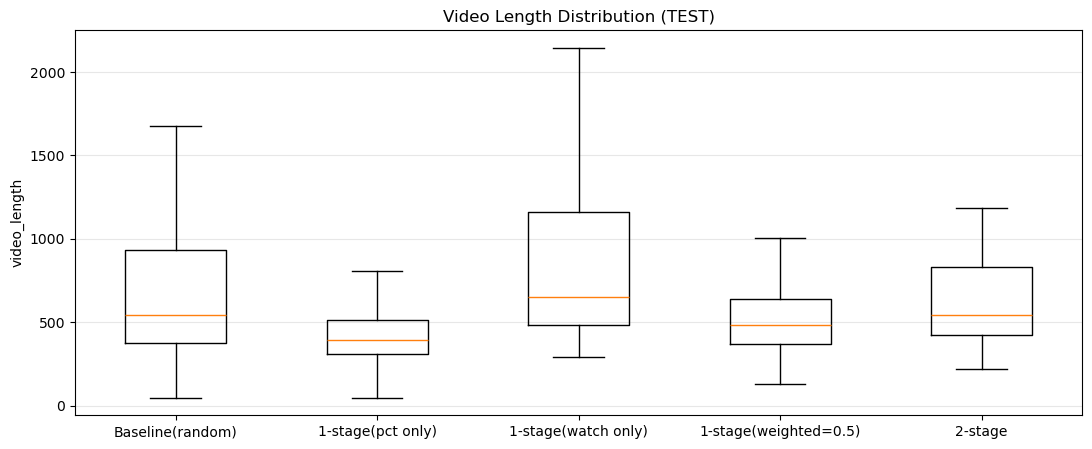

In [100]:
plt.figure(figsize=(13,5))
plt.boxplot(
    [score_te["video_length"], slate_pct_te["video_length"],slate_watch_te['video_length'], slate_balanced_te["video_length"], slate_two_stage_te["video_length"]],
    tick_labels=["Baseline(random)", "1-stage(pct only)","1-stage(watch only)","1-stage(weighted=0.5)", "2-stage"],
    showfliers=False
)
plt.ylabel("video_length")
plt.title("Video Length Distribution (TEST)")
plt.grid(axis="y", alpha=0.3)
plt.savefig("../reports/figures/video_length_distribution_test.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()

###  KPI uplift vs Random baseline (TEST)

These two plots highlight the **trade-off** between optimizing **completion depth (% viewed)** and **total watch time** when ranking a daily Top-K slate.

**Avg % Viewed uplift (top plot)**
- **1-stage (pct-only)** delivers the largest gain in completion depth (**≈ +0.096**), meaning it selects videos users are more likely to finish.
- **1-stage (watch-only)** hurts completion depth (**≈ −0.038**), consistent with selecting longer videos that are harder to complete.
- **Balanced (w_pct = 0.50)** provides a moderate improvement (**≈ +0.041**) without collapsing watch time.
- **2-stage (pct→watch)** is almost neutral on % viewed (**≈ +0.003**).

**Watch Time uplift (bottom plot)**
- **1-stage (watch-only)** achieves the biggest watch-time increase (**≈ +34.19**), as expected.
- **1-stage (pct-only)** substantially reduces watch time (**≈ −46.47**), suggesting it over-selects shorter/easier-to-finish videos.
- **Balanced (w_pct = 0.50)** is slightly positive (**≈ +1.84**), indicating a more stable compromise.
- **2-stage (pct→watch)** improves watch time modestly (**≈ +8.38**) while keeping % viewed near baseline.

**Takeaway**
- The results confirm a clear **KPI trade-off**: pushing % viewed up tends to pull watch time down, and vice versa.
- **Balanced (w_pct = 0.50)** is a reasonable “middle-ground” policy when we want **both** KPIs to be non-negative (or at least not extreme) relative to the random baseline.

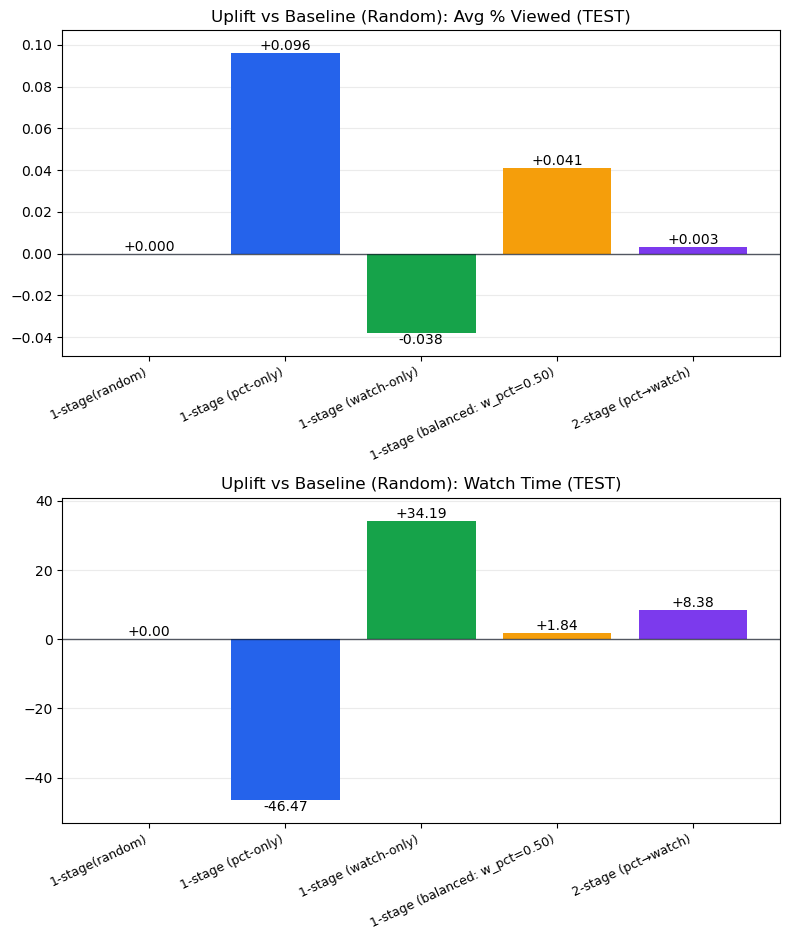

Saved: ../reports/figures/test_kpis_comparison.png


In [91]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- TEST results (from your table) ---
labels = [
    "1-stage(random)",
    "1-stage (pct-only)",
    "1-stage (watch-only)",
    "1-stage (balanced: w_pct=0.50)",
    "2-stage (pct→watch)"
]

# Baseline = TEST random baseline (K=100)
pct_base = 0.349785
watch_base = 211.425101

# Order must match labels above
pct_stage = [0.349785, 0.445694, 0.311967, 0.390925, 0.353088]
pct_uplift = [v - pct_base for v in pct_stage]

watch_stage = [211.425101, 164.956516, 245.616420, 213.264905, 219.801734]
watch_uplift = [v - watch_base for v in watch_stage]

os.makedirs("../reports/figures", exist_ok=True)

# ---- color mapping (one color per policy) ----
color_map = {
    "1-stage(random)": "#9CA3AF",                 # gray
    "1-stage (pct-only)": "#2563EB",              # blue
    "1-stage (watch-only)": "#16A34A",            # green
    "1-stage (balanced: w_pct=0.50)": "#F59E0B",  # amber
    "2-stage (pct→watch)": "#7C3AED"              # purple
}
colors = [color_map[l] for l in labels]

def uplift_subplot(ax, title, uplift, fmt):
    x = np.arange(len(labels))

    bars = ax.bar(x, uplift, color=colors)
    ax.axhline(0, linewidth=1, color="#111827", alpha=0.7)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=25, ha="right", fontsize=9)

    ax.set_title(title)
    ax.grid(axis="y", alpha=0.25)
    ax.set_axisbelow(True)

    # give a bit of headroom for text labels
    ymin, ymax = ax.get_ylim()
    pad = 0.15 * (ymax - ymin) if (ymax - ymin) > 0 else 1
    ax.set_ylim(ymin - pad*0.2, ymax + pad*0.2)

    for b, v in zip(bars, uplift):
        ax.text(
            b.get_x() + b.get_width()/2,
            v,
            fmt.format(v),
            ha="center",
            va="bottom" if v >= 0 else "top",
            fontsize=10
        )

# ---- one combined figure ----
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 9.5))

uplift_subplot(axes[0], "Uplift vs Baseline (Random): Avg % Viewed (TEST)", pct_uplift, "{:+.3f}")
uplift_subplot(axes[1], "Uplift vs Baseline (Random): Watch Time (TEST)", watch_uplift, "{:+.2f}")

fig.tight_layout()

outpath = "../reports/figures/test_kpis_comparison.png"
fig.savefig(outpath, dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print("Saved:", outpath)

### TEST Results Summary: KPI Trade-off Across Policies (K=100)

This figure/table reports the **true next-day outcomes** on the **TEST** split for each daily Top-K slate.

#### Baseline (Random)
- **Avg % Viewed:** **0.3498**
- **Watch Time:** **211.43**
- Used as the **reference point** for uplift.


### Policy Outcomes (vs Random Baseline)

#### 1) 1-stage (pct-only)
- **Avg % Viewed:** **0.4457** (**+0.0959**)
- **Watch Time:** **164.96** (**-46.47**)
**Interpretation:** Maximizing completion depth strongly increases **% viewed**, but it tends to over-select **short / easy-to-finish** videos, reducing total watch time.


#### 2) 1-stage (watch-only)
- **Avg % Viewed:** **0.3120** (**-0.0378**)
- **Watch Time:** **245.62** (**+34.19**)
**Interpretation:** Maximizing watch time favors **longer videos**, increasing total minutes watched but lowering completion fraction.


#### 3) 1-stage (balanced weighted, w_pct = 0.50)
- **Avg % Viewed:** **0.3909** (**+0.0411**)
- **Watch Time:** **213.26** (**+1.84**)
**Interpretation:** The weighted score provides a **middle-ground**: meaningful gain in completion depth while keeping watch time close to baseline (slightly higher).


#### 4) 2-stage (pct → watch)
- **Avg % Viewed:** **0.3531** (**+0.0033**)
- **Watch Time:** **219.80** (**+8.38**)
**Interpretation:** Two-stage recovers watch time by reranking within a completion-filtered candidate set. Here it improves watch time with only a small change in % viewed.


### Key Takeaway
Different objectives produce **different slates**, so even with the same predictions, the **ranking policy** determines the KPI trade-off.

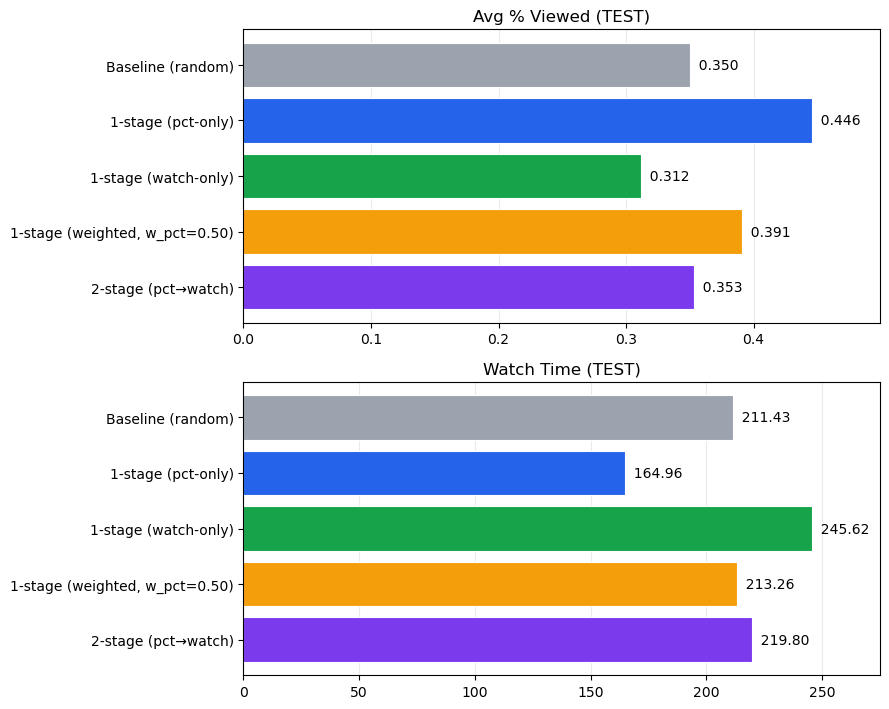

Saved: ../reports/figures/kpis_test.png


In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- TEST results (from your table) ---
labels = [
    "Baseline (random)",
    "1-stage (pct-only)",
    "1-stage (watch-only)",
    "1-stage (weighted, w_pct=0.50)",
    "2-stage (pct→watch)"
]

# Baseline == random baseline in your TEST results
pct = [
    0.349785,  # baseline (random)
    0.445694,  # pct-only
    0.311967,  # watch-only
    0.390925,  # weighted (w_pct=0.50)
    0.353088   # 2-stage
]

watch = [
    211.425101,  # baseline (random)
    164.956516,  # pct-only
    245.616420,  # watch-only
    213.264905,  # weighted (w_pct=0.50)
    219.801734   # 2-stage
]

# --- colors: one per policy (same across both charts) ---
colors = [
    "#9CA3AF",  # Baseline-random(lighter gray)
    "#2563EB",  # pct-only (blue)
    "#16A34A",  # watch-only (green)
    "#F59E0B",  # weighted (orange)
    "#7C3AED",  # 2-stage (purple)
]

os.makedirs("../reports/figures", exist_ok=True)

def nice_barh_two(title1, values1, fmt1, title2, values2, fmt2, labels, colors):
    y = np.arange(len(labels))
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9.0, 7.2))

    for ax, title, values, fmt in [
        (axes[0], title1, values1, fmt1),
        (axes[1], title2, values2, fmt2),
    ]:
        bars = ax.barh(y, values, color=colors, edgecolor="white", linewidth=0.8)
        ax.set_yticks(y)
        ax.set_yticklabels(labels)
        ax.invert_yaxis()
        ax.set_title(title)
        ax.grid(axis="x", alpha=0.25)
        ax.set_axisbelow(True)
        ax.margins(x=0.12)

        # annotate values at end of bars
        for b, v in zip(bars, values):
            ax.text(
                v, b.get_y() + b.get_height()/2,
                f"  {fmt.format(v)}",
                va="center", fontsize=10
            )

    fig.tight_layout()
    return fig

fig = nice_barh_two(
    "Avg % Viewed (TEST)", pct, "{:.3f}",
    "Watch Time (TEST)", watch, "{:.2f}",
    labels, colors
)

outpath = "../reports/figures/kpis_test.png"
fig.savefig(outpath, dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print("Saved:", outpath)